In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy import stats
from datetime import datetime, timedelta

In [3]:
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Loading Data

In [4]:
file_load = 'C:\\ny_load_correct.csv'

In [5]:
df = pd.read_csv(file_load)
df.columns = ['date', 'load']

In [6]:
df['date'] = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M')

In [7]:
file_weather = 'C:\\ny_weather_correct.csv'

In [8]:
df_weather = pd.read_csv(file_weather)
df_weather.columns = ['date', 'temp', 'humid']

In [9]:
df_weather['date'] = pd.to_datetime(df_weather.date, format='%d/%m/%Y %H:%M')

In [10]:
# Putting both DFs together
df = pd.merge(df, df_weather, on=['date'])

In [11]:
# Drop 2020 data
df = df[df.date < '2020-01-01 00:00:00']

In [12]:
df

,date,load,temp,humid
0,2015-07-02 00:00:00,18493,23.9,55.0
1,2015-07-02 01:00:00,17090,22.8,61.0
2,2015-07-02 02:00:00,16052,22.2,61.0
3,2015-07-02 03:00:00,15356,22.2,59.0
4,2015-07-02 04:00:00,14936,21.1,66.0
...,...,...,...,...
39447,2019-12-31 19:00:00,19437,6.7,73.0
39448,2019-12-31 20:00:00,18778,6.1,73.0
39449,2019-12-31 21:00:00,18082,6.1,68.0
39450,2019-12-31 22:00:00,17385,5.6,62.0


# Initial Data Engineering

In [13]:
time_deltas = df['date'].diff()[1:]

In [14]:
gaps = time_deltas[time_deltas > timedelta(hours=1)]

In [15]:
print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')
for i, g in gaps.iteritems():
    gap_start = df['date'][i - 1]
    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')

4 gaps with average gap duration: 0 days 02:00:00
Start: 2016-03-13 | Duration: 2:00:00
Start: 2017-03-12 | Duration: 2:00:00
Start: 2018-03-11 | Duration: 2:00:00
Start: 2019-03-10 | Duration: 2:00:00


There are **five timestamp gaps in the DataFrame** of one hour gaps in each instance.

In [16]:
df[df.date >= '2016-03-13 00:00:00'].head(5)

,date,load,temp,humid
6120,2016-03-13 00:00:00,14377,11.1,59.0
6121,2016-03-13 01:00:00,13536,11.1,59.0
6122,2016-03-13 03:00:00,12975,11.1,59.0
6123,2016-03-13 04:00:00,12701,11.1,59.0
6124,2016-03-13 05:00:00,12596,11.7,56.0


In [17]:
df[df.date >= '2018-03-11 00:00:00'].head(5)

,date,load,temp,humid
23590,2018-03-11 00:00:00,16111,1.7,54.0
23591,2018-03-11 01:00:00,15360,1.7,54.0
23592,2018-03-11 03:00:00,14857,1.1,54.0
23593,2018-03-11 04:00:00,14545,1.1,54.0
23594,2018-03-11 05:00:00,14488,0.6,56.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39452 entries, 0 to 39451
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    39452 non-null  datetime64[ns]
 1   load    39452 non-null  int64         
 2   temp    39361 non-null  float64       
 3   humid   39355 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 2.5 MB


In [19]:
# Setting the DatetimeIndex with hourly frequency will force the occurence of the missing timestamps with NaN values 
# provided for the variables
df = df.set_index('date').asfreq('h')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39456 entries, 2015-07-02 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    39452 non-null  float64
 1   temp    39361 non-null  float64
 2   humid   39355 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


### Adding seasonal variables

In [21]:
df['year'] = df.index.year.astype('int')

In [22]:
df['month'] = df.index.month.astype('int')

In [23]:
df['hour'] = df.index.hour.astype('int')

### Missing value imputation

In [24]:
df.describe()

,load,temp,humid,year,month,hour
count,39452.000000,39361.000000,39355.000000,39456.000000,39456.000000,39456.000000
mean,18149.769669,13.931194,61.891631,2017.220803,6.855231,11.500000
std,3416.880587,9.741816,19.210715,1.315017,3.431644,6.922274
min,11831.000000,-18.300000,9.000000,2015.000000,1.000000,0.000000
25%,15766.000000,6.100000,47.000000,2016.000000,4.000000,5.750000
50%,17814.500000,14.400000,60.000000,2017.000000,7.000000,11.500000
75%,19859.000000,22.200000,77.000000,2018.000000,10.000000,17.250000
max,32076.000000,35.600000,100.000000,2019.000000,12.000000,23.000000


Will replace the NaN values of each variable with its **mean grouped by the year, month and hour**.

In [25]:
df['load_mean'] = df.groupby(['year', 'month', 'hour'])['load'].transform(lambda x: x.fillna(x.mean()))

In [26]:
df['temp_mean'] = df.groupby(['year', 'month', 'hour'])['temp'].transform(lambda x: x.fillna(x.mean()))

In [27]:
df['humid_mean'] = df.groupby(['year', 'month', 'hour'])['humid'].transform(lambda x: x.fillna(x.mean()))

In [28]:
df['load'] = df['load'].fillna(df.load_mean)

In [29]:
df['temp'] = df['temp'].fillna(df.temp_mean)

In [30]:
df['humid'] = df['humid'].fillna(df.humid_mean)

In [31]:
df.drop(['load_mean', 'temp_mean', 'humid_mean'], axis=1, inplace=True)

In [32]:
df.describe()

,load,temp,humid,year,month,hour
count,39456.000000,39456.000000,39456.000000,39456.000000,39456.000000,39456.000000
mean,18149.408984,13.919316,61.886872,2017.220803,6.855231,11.500000
std,3416.897496,9.738257,19.189094,1.315017,3.431644,6.922274
min,11831.000000,-18.300000,9.000000,2015.000000,1.000000,0.000000
25%,15766.000000,6.100000,47.000000,2016.000000,4.000000,5.750000
50%,17814.000000,14.400000,60.000000,2017.000000,7.000000,11.500000
75%,19859.000000,22.200000,77.000000,2018.000000,10.000000,17.250000
max,32076.000000,35.600000,100.000000,2019.000000,12.000000,23.000000


In [33]:
# Check for any NaN values across rows
df[df.isin([np.nan]).any(axis=1)].count().sum()

0

In [34]:
# No infinite values in DF
df[df.isin([np.inf, -np.inf]).any(axis=1)].count().sum()

0

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39456 entries, 2015-07-02 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    39456 non-null  float64
 1   temp    39456 non-null  float64
 2   humid   39456 non-null  float64
 3   year    39456 non-null  int64  
 4   month   39456 non-null  int64  
 5   hour    39456 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 2.1 MB


# Functions

In [36]:
def seasonal_mean(df, season_var, con_var):
    """
    Generates the mean of the seasonal period of choice, plus the upper and lower Confidence Intervals
    
    df: DataFrame of dataset
    season_var: Seasonal categorical variable - day/hour/month
    con_var: Continuous variable providing the "mean" reading of interest
    n_sample: Number of samples for each mean reading
    
    """
    
    mean_dict = dict(df.groupby(season_var)[con_var].mean())
    
    n = df.groupby(season_var)[con_var].count().mean()
    
    upper_dict = dict(df.groupby(season_var)[con_var].mean() + 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    lower_dict = dict(df.groupby(season_var)[con_var].mean() - 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    mean_df = pd.DataFrame([mean_dict, upper_dict, lower_dict]).transpose()
    mean_df.columns = ['mean', 'upper_CI', 'lower_CI']
    
    return mean_df


In [37]:
def adf_statistics(series):
    """
    Function to output Augmented Dickey-Fuller test for stationarity
    
    series: Time series of interest
    """
    result = adfuller(series.values)
    
    print('ADF Statistic: %.4f' % result[0])
    print('p-value: %.4f' % result[1])
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.4f' % (key, value))
    if result[1] < 0.0500:
        print("Null hypothesis of non-stationarity is rejected")
    else:
        print("Null hypothesis of non-stationarity is NOT rejected")


In [38]:
# Function for sin-cosine cyclic transformation
def cyclic_transform(column):
    max_val = column.max()
    sine = [np.sin((2 * np.pi * i)/max_val) for i in list(column)]
    cosine = [np.cos((2 * np.pi * i)/max_val) for i in list(column)]
    return sine, cosine


# EDA of Target

In [39]:
df.groupby(['year'])['load'].mean()

year
2015    18665.525046
2016    18305.902789
2017    17850.276975
2018    18393.067812
2019    17789.194570
Name: load, dtype: float64

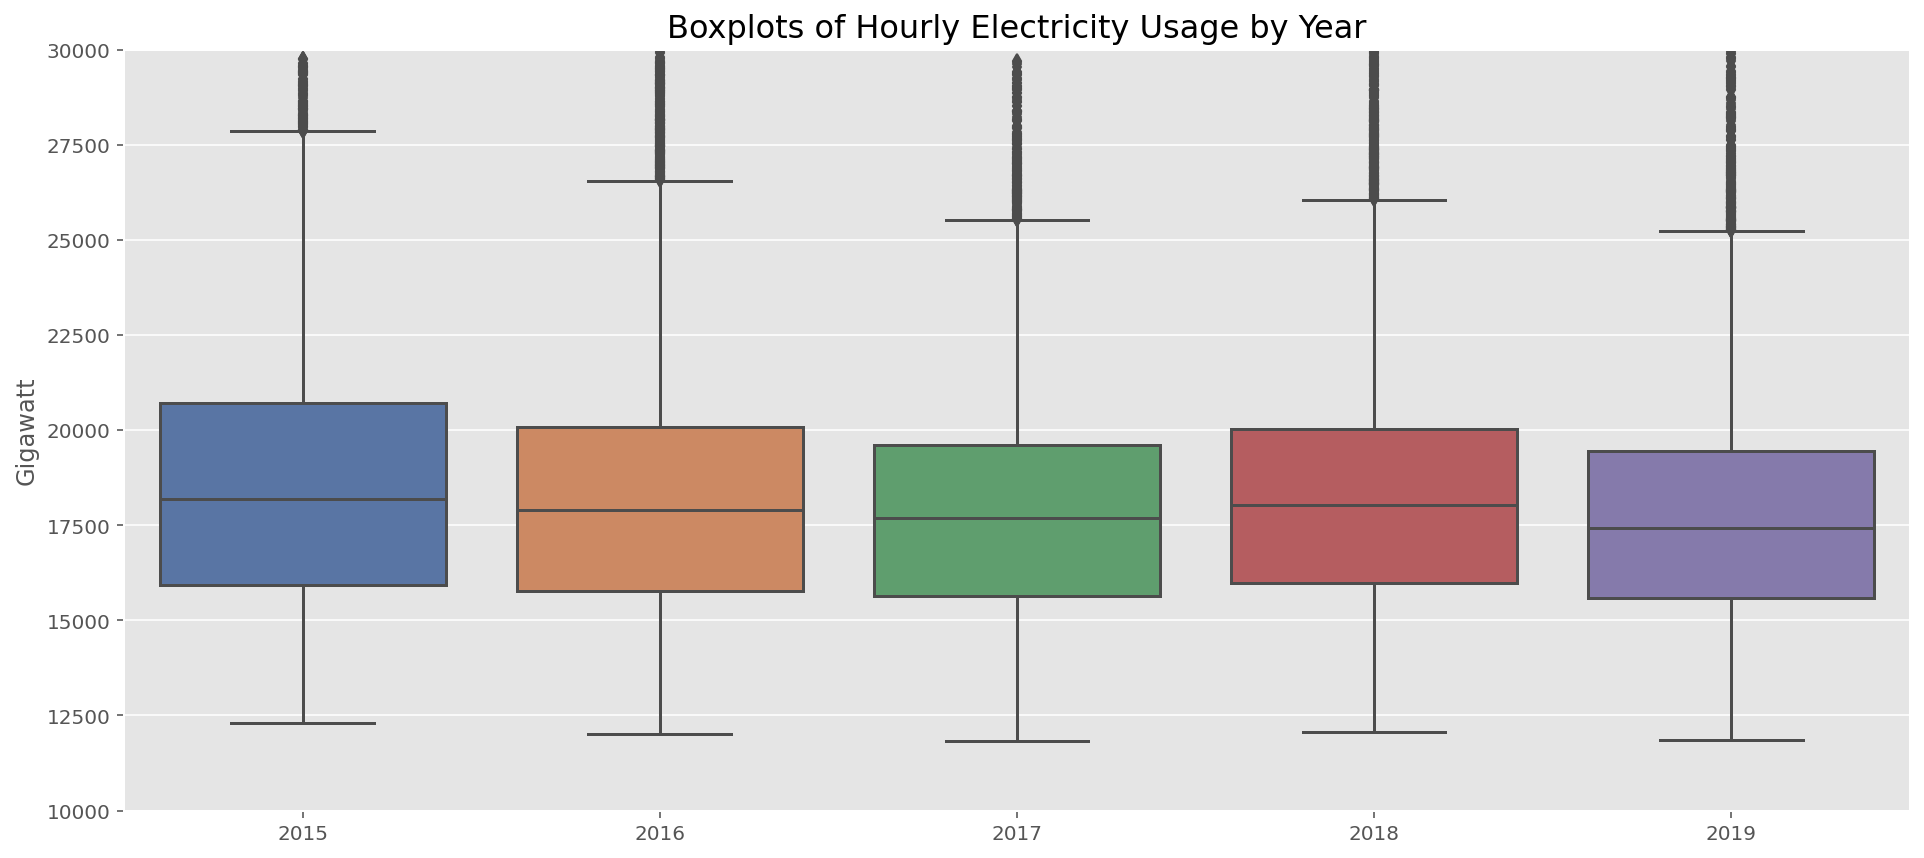

In [40]:
# Box-plots for 'load' indicating no major trends in the distributions across the years
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='year', y='load', data=df, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(10000, 30000))

plt.title('Boxplots of Hourly Electricity Usage by Year', fontsize=16)
plt.xlabel('')
plt.ylabel('Gigawatt', fontsize=12);

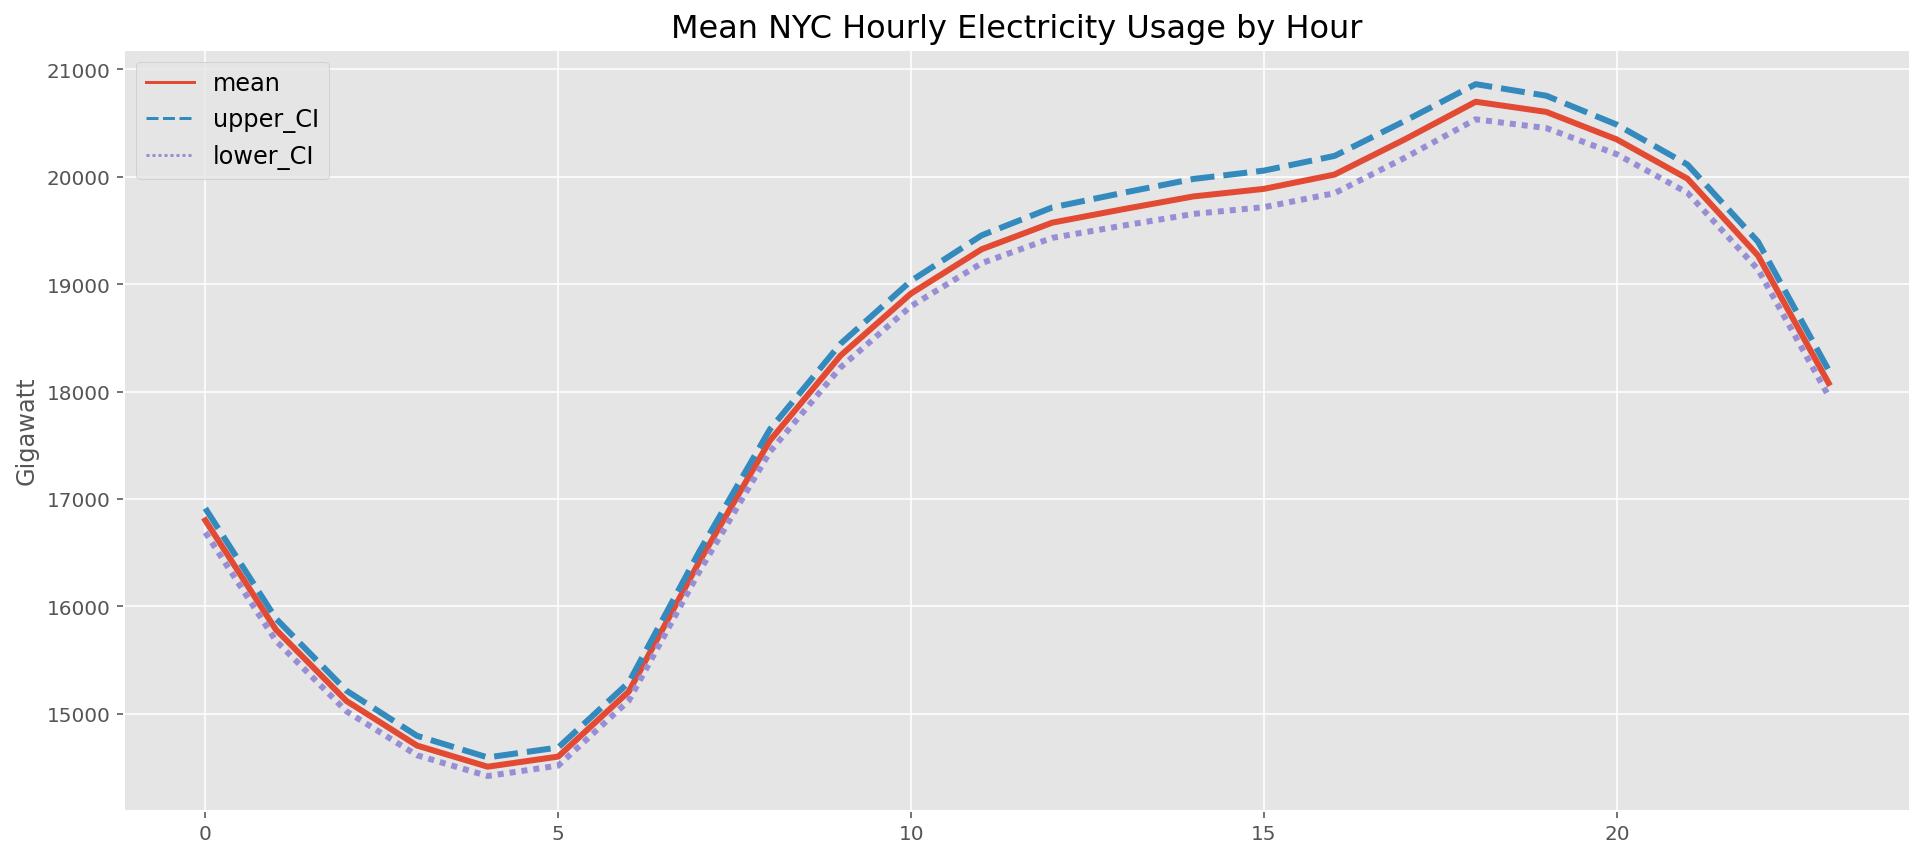

In [41]:
hour_avg = seasonal_mean(df, 'hour', 'load')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper left', fontsize=12)
plt.title('Mean NYC Hourly Electricity Usage by Hour', fontsize=16)
plt.xlabel('')
plt.ylabel('Gigawatt', fontsize=12);

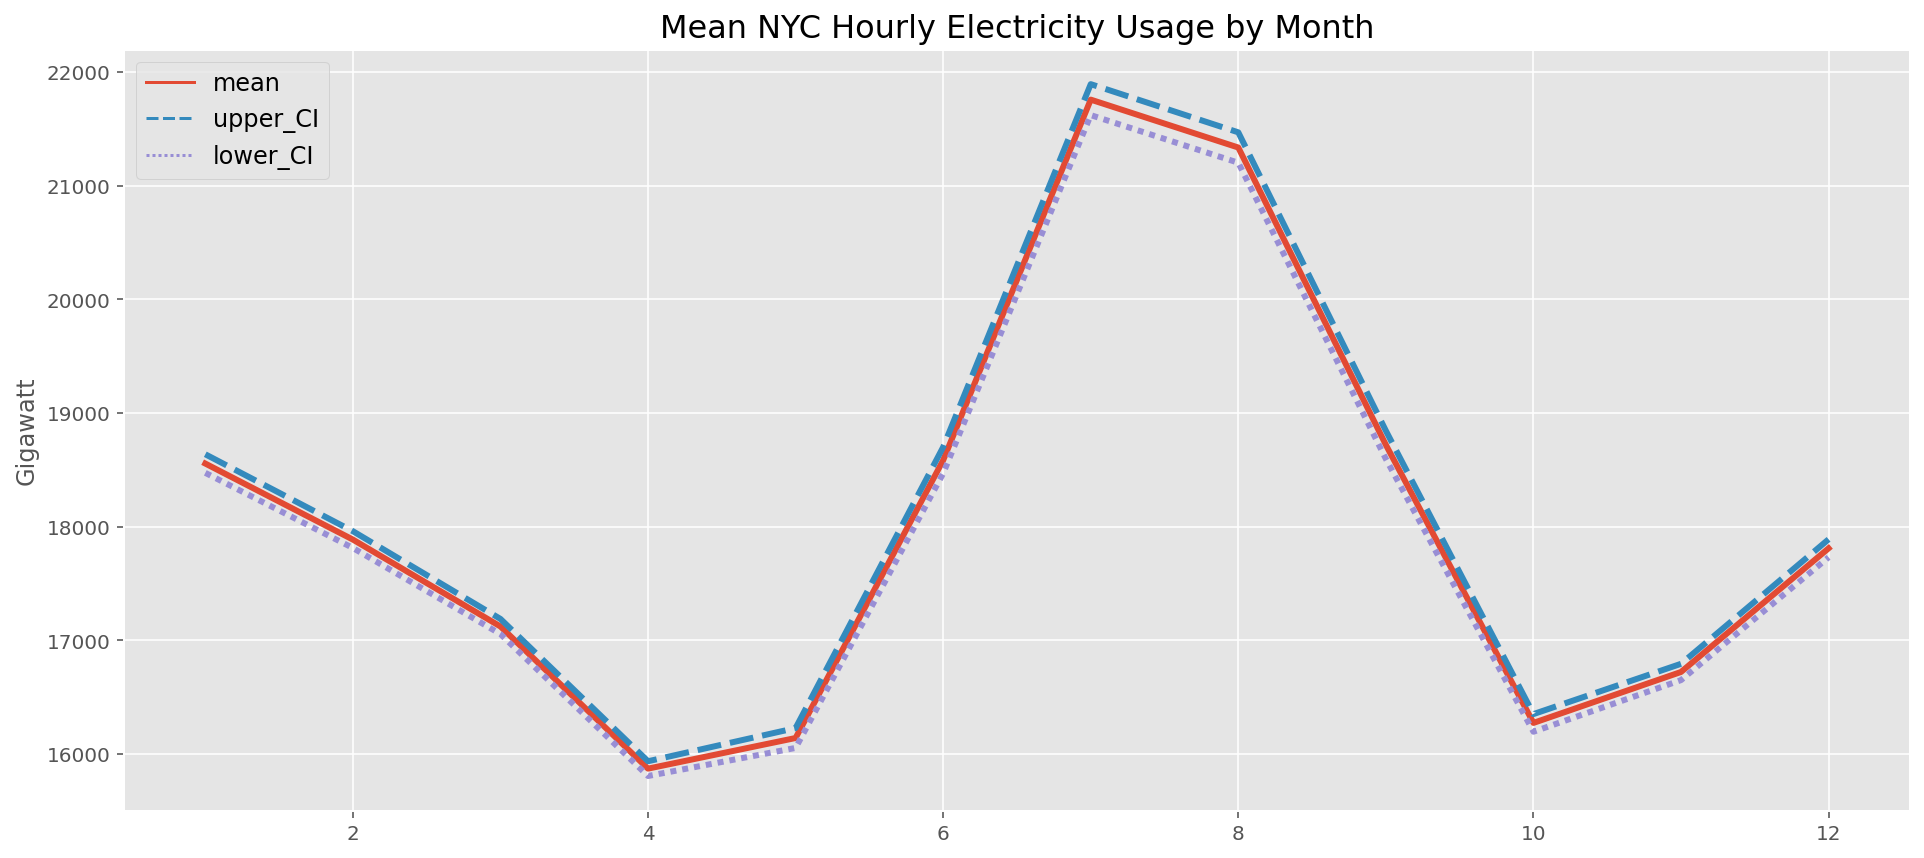

In [42]:
month_avg = seasonal_mean(df, 'month', 'load')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper left', fontsize=12)
plt.title('Mean NYC Hourly Electricity Usage by Month', fontsize=16)
plt.xlabel('')
plt.ylabel('Gigawatt', fontsize=12);

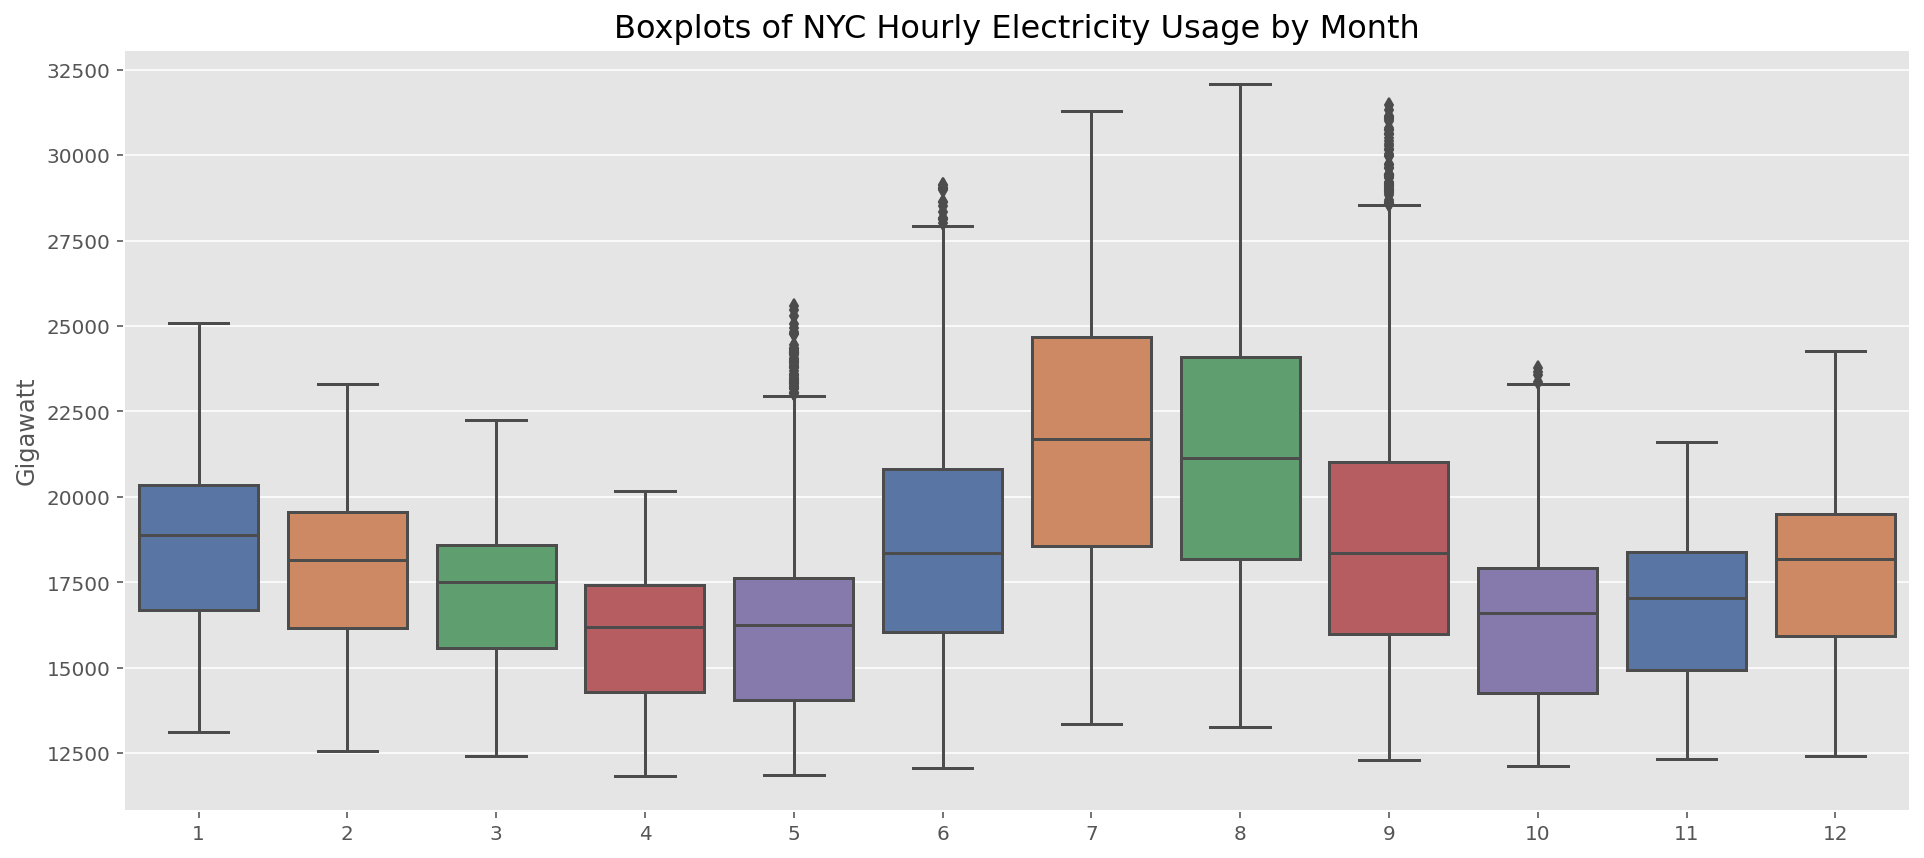

In [43]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='month', y='load', data=df, orient='v', palette = sns.color_palette("deep", 5))

plt.title('Boxplots of NYC Hourly Electricity Usage by Month', fontsize=16)
plt.xlabel('')
plt.ylabel('Gigawatt', fontsize=12);

### Standardizing target variable

In [44]:
scaler = StandardScaler()

In [45]:
# Standardise the target data, and the output are two Numpy arrays
df['load_scaled'] = scaler.fit_transform(df[['load']]) 

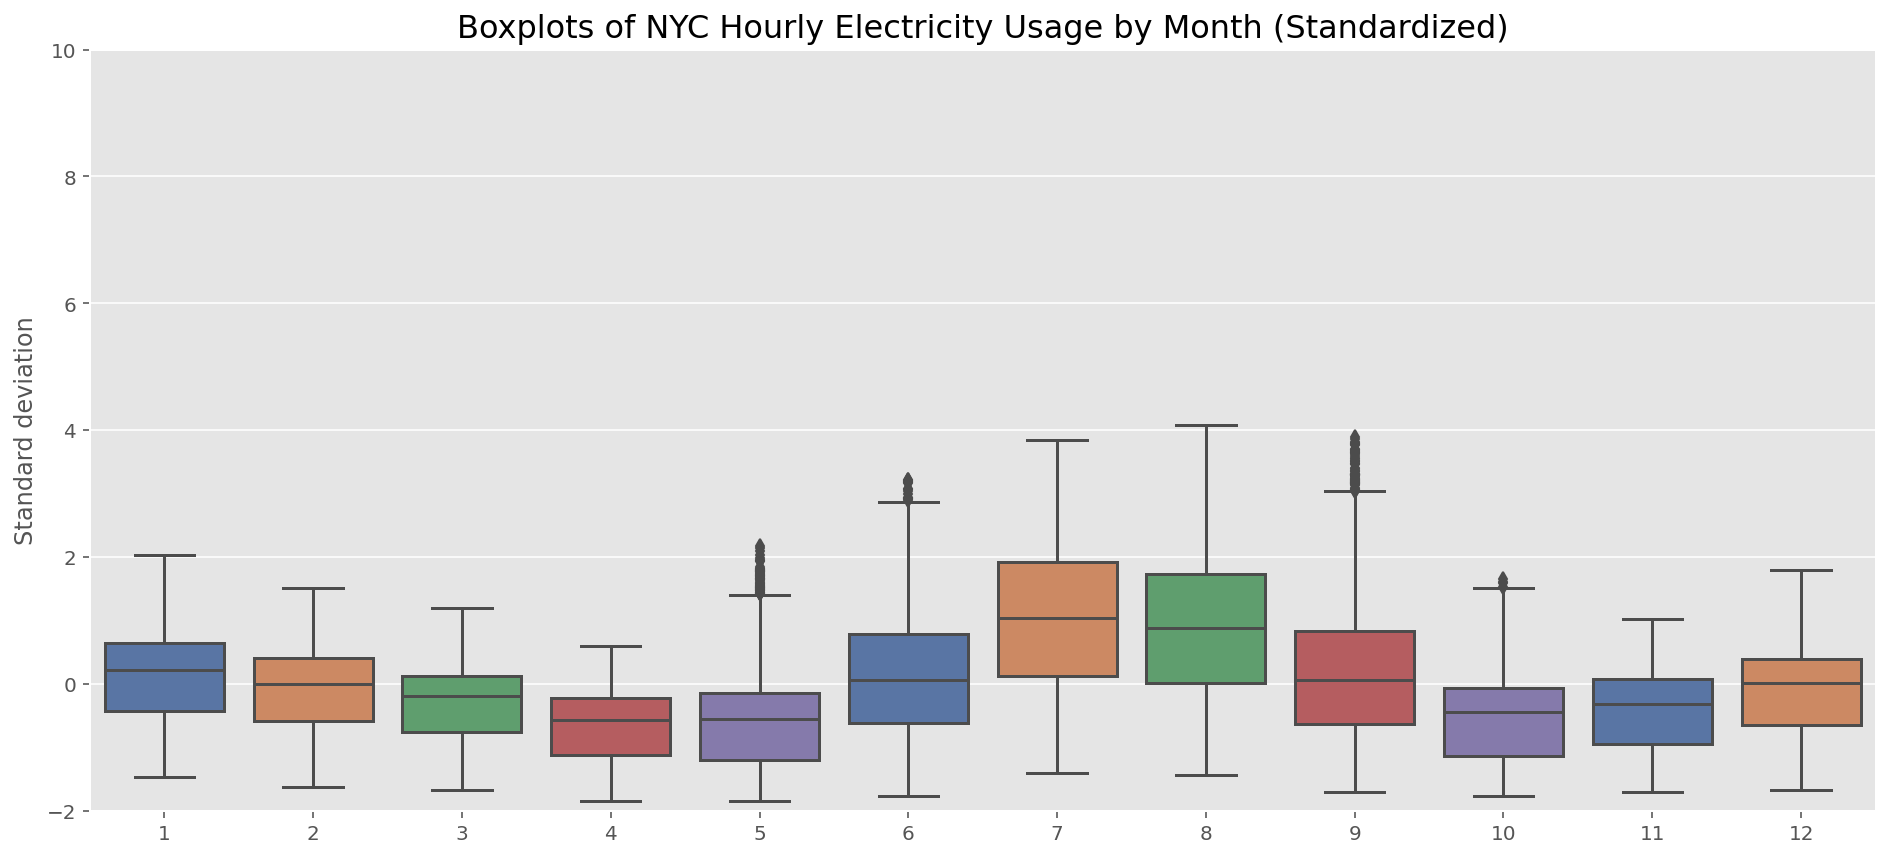

In [46]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='month', y='load_scaled', data=df, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-2, 10))

plt.title('Boxplots of NYC Hourly Electricity Usage by Month (Standardized)', fontsize=16)
plt.xlabel('')
plt.ylabel('Standard deviation', fontsize=12);

# Stationarity Tests

In [47]:
adf_statistics(df.load)

ADF Statistic: -10.6255
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


In [48]:
adf_statistics(df.temp)

ADF Statistic: -7.1471
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


In [49]:
adf_statistics(df.humid)

ADF Statistic: -21.6478
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


# Additional Data Engineering

### Create weekend dummy

In [50]:
# Subsetting by weekends
we = df.loc[df.index.weekday >= 5]['load']

In [51]:
# Subsetting by weekdays
wd = df.loc[df.index.weekday < 5]['load']

In [52]:
# There is a statistically significant impact on 'load' on weekends
stats.ttest_ind(we, wd, equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-43.49062883774102, pvalue=0.0)

In [53]:
# Generate weekend dummy
df['wkend'] = (df.index.weekday < 5).astype('int')

### Create one-period ahead target & date variables

In [54]:
# Generate the one-period ahead target variable
df['target'] = df['load'].shift(-1)

Create **contemporaneous time/seasonal** variables that are **concurrent** with the target variable. Time is **deterministic**, e.g. 9pm will follow 8pm and May will follow April, so the time variables may be set concurrent with the one-period target.

In [55]:
df['cmonth'] = df['month'].shift(-1)
df['chour'] = df['hour'].shift(-1)
df['cwkend'] = df['wkend'].shift(-1)

Delete resulting null values

In [56]:
df = df[~df['target'].isnull()]

### Miscellaneous

In [57]:
# Dropping unnecessary and redundant variables...
df.drop(['year', 'month', 'hour', 'wkend', 'load_scaled'], axis=1, inplace=True)

In [58]:
df['date'] = df.index

### Create cyclic time variables

In [59]:
df['mth_sin'], df['mth_cos'] = cyclic_transform(df.cmonth)

In [60]:
df['hour_sin'], df['hour_cos'] = cyclic_transform(df.chour)

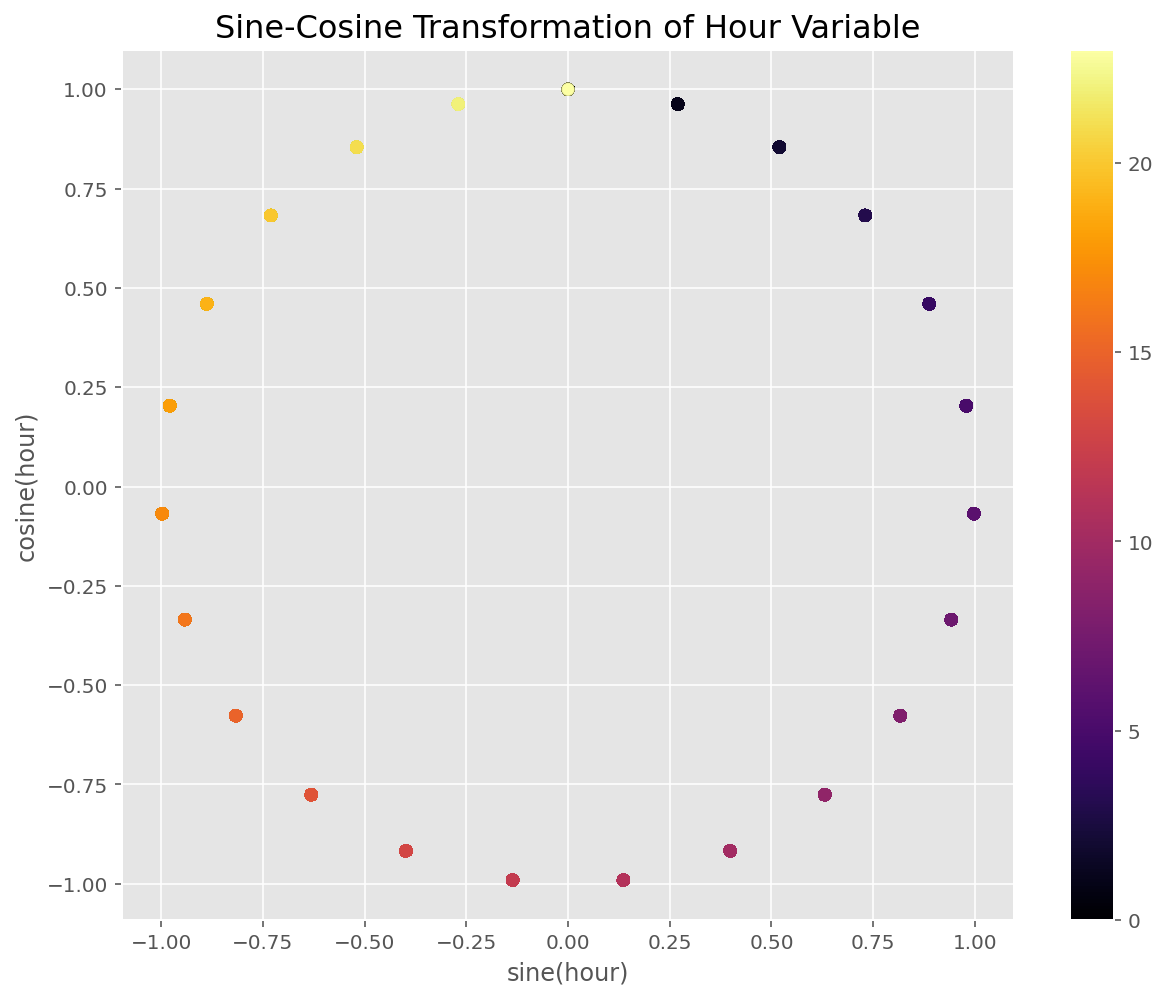

In [61]:
fig, ax = plt.subplots(figsize=(10,8))

sp = ax.scatter(df.hour_sin, df.hour_cos, c=df.chour, cmap='inferno')
_ = fig.colorbar(sp)

plt.title('Sine-Cosine Transformation of Hour Variable', fontsize=16)
plt.xlabel('sine(hour)')
plt.ylabel('cosine(hour)', fontsize=12);

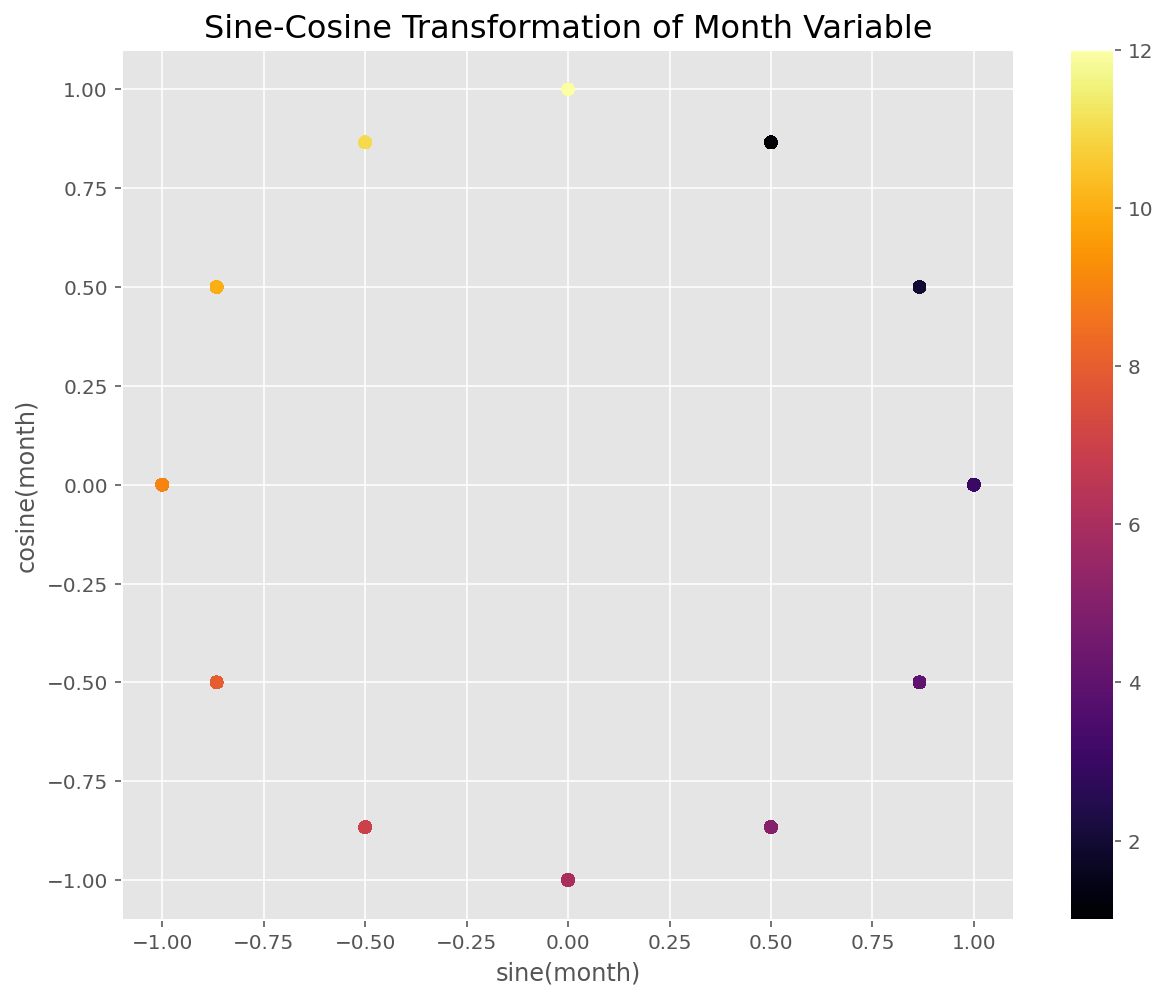

In [62]:
fig, ax = plt.subplots(figsize=(10,8))

sp = ax.scatter(df.mth_sin, df.mth_cos, c=df.cmonth, cmap='inferno')
_ = fig.colorbar(sp)

plt.title('Sine-Cosine Transformation of Month Variable', fontsize=16)
plt.xlabel('sine(month)')
plt.ylabel('cosine(month)', fontsize=12);

### Create dummy variables from month & hour numeric variables

In [63]:
# First generate hour and month numeric variables
df['hour_num'] = df['chour']
df['mth_num'] = df['cmonth']

In [64]:
# Transform the contemporaneous month and hour categorical variables into dummies
df = pd.get_dummies(df, columns=['cmonth', 'chour'], drop_first=True)

In [65]:
df[['hour_num', 'chour_3.0', 'chour_19.0', 'chour_22.0']]

,hour_num,chour_3.0,chour_19.0,chour_22.0
date,,,,
2015-07-02 00:00:00,1.0,0,0,0
2015-07-02 01:00:00,2.0,0,0,0
2015-07-02 02:00:00,3.0,1,0,0
2015-07-02 03:00:00,4.0,0,0,0
2015-07-02 04:00:00,5.0,0,0,0
...,...,...,...,...
2019-12-31 18:00:00,19.0,0,1,0
2019-12-31 19:00:00,20.0,0,0,0
2019-12-31 20:00:00,21.0,0,0,0


In [66]:
df.isnull().values.any()

False

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39455 entries, 2015-07-02 00:00:00 to 2019-12-31 22:00:00
Freq: H
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   load         39455 non-null  float64       
 1   temp         39455 non-null  float64       
 2   humid        39455 non-null  float64       
 3   target       39455 non-null  float64       
 4   cwkend       39455 non-null  float64       
 5   date         39455 non-null  datetime64[ns]
 6   mth_sin      39455 non-null  float64       
 7   mth_cos      39455 non-null  float64       
 8   hour_sin     39455 non-null  float64       
 9   hour_cos     39455 non-null  float64       
 10  hour_num     39455 non-null  float64       
 11  mth_num      39455 non-null  float64       
 12  cmonth_2.0   39455 non-null  uint8         
 13  cmonth_3.0   39455 non-null  uint8         
 14  cmonth_4.0   39455 non-null  uint8         
 15  cmonth_5.0

In [68]:
# Saving engineered dataset
#df.to_csv(r'C:\\ny_engineered.csv', index=False)